In [46]:
import gymnasium as gym
import mujoco_py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [47]:
import rpo.rpo as rpo

In [48]:
params = {
    'env_id': "Ant-v4" ,
    'num_envs' : 6 , 
    'num_steps' : 500 , 
    'num_minibatches' : 6 , 
    'total_timesteps' : 150000 ,
    'gamma' : 0.98 ,
    'gae_lambda' : 0.95 ,
    'update_epochs' : 10 ,
    'clip_coef':2 ,
    'clip_vloss': True ,
    'ent_coef': 0.0 ,
    'vf_coef': 0.5 ,
    'learning_rate' : 3e-4 ,
    'max_grad_norm': 0.5
    
}

In [49]:
def make_env(env_id):
    def make():
        env = gym.make(env_id)
        return env

    return make

In [50]:
envs = gym.vector.SyncVectorEnv(
    [make_env(params['env_id']) for i in range(params['num_envs'])]
)

# Main


In [51]:
agent = rpo.RPO_Agent()
net = rpo.Network(envs , alpha=0.5)
optimizer = optim.Adam(net.parameters() , lr=params['learning_rate'], eps=1e-5)


params['batch_size'] = int(params['num_envs'] * params['num_steps'])
params['minibatch_size'] = int(params['batch_size'] // params['num_minibatches'])
params['num_iterations'] = params['total_timesteps'] // params['batch_size']

obs , actions , logprobs , rewards , dones , values = agent.storage_setup(params['num_steps'] , params['num_envs'] , envs.single_observation_space.shape , envs.single_action_space.shape) 





next_obs, _ = envs.reset(seed=42)
next_obs = torch.Tensor(next_obs)
next_done = torch.zeros(params['num_envs'])
num_updates = params['total_timesteps'] // params['batch_size']

global_step = 0


# Lists to collect data
pg_loss_list = []
value_loss_list = []
reward_list = []

for update in range(1, num_updates + 1):
    print(f'Iteration: {update}/{params["num_iterations"]}', end='\r', flush=True)
    reward_total = np.zeros(params['num_envs'])

    for step in range(0, params['num_steps']):
        
        global_step += 1 * params['num_envs']
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            action, logprob, _, value = net.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        next_obs, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        

        done = np.logical_or(terminations, truncations)
        rewards[step] = torch.tensor(reward).view(-1)
        next_obs, next_done = torch.Tensor(next_obs) , torch.Tensor(done)
        reward_total += reward
    reward_list.append(reward_total)
    print('Iteration ', update, ' Reward: ', reward_total)

    with torch.no_grad():
        next_value = net.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards)

        advantages = agent.get_advantages(params['num_steps'] , next_done , next_value , dones , values , rewards , params['gamma'] , params['gae_lambda'])

        returns = advantages + values

        b_obs , b_logprobs , b_actions ,b_advantages , b_returns , b_values = agent.flatten_batch(obs , logprobs , actions ,advantages , returns , values , envs.single_observation_space.shape , envs.single_action_space.shape)


    b_inds = np.arange(params['batch_size'])
    clipfracs = []
    for epoch in range(params['update_epochs']):
        np.random.shuffle(b_inds)
        for start in range(0, params['batch_size'], params['minibatch_size']):
            end = start + params['minibatch_size']
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = net.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            pg_loss = agent.get_policy_loss(logratio , ratio , b_advantages , mb_inds , params['clip_coef'] , clipfracs)
            v_loss = agent.get_value_loss(params['clip_vloss'] , b_returns , mb_inds , b_values , params['clip_coef'] , newvalue)
            entropy_loss = entropy.mean()

            loss = pg_loss - params['ent_coef'] * entropy_loss + v_loss * params['vf_coef']

            pg_loss_list.append(pg_loss.item())
            value_loss_list.append(v_loss.item())


            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), params['max_grad_norm'])
            optimizer.step()



Iteration  1  Reward:  [-1657.64587212 -1492.73058712 -1631.12887833 -1604.62458985
 -1518.32014698 -1680.41222655]
Iteration  2  Reward:  [-1652.52555478 -1653.84915954 -1670.45753336 -1718.95273559
 -1586.69754711 -1650.4492835 ]
Iteration  3  Reward:  [-1780.43529035 -1656.57742699 -1788.31192633 -1721.32954455
 -1554.73389778 -1658.42087917]
Iteration  4  Reward:  [-1623.5833745  -1619.15549009 -1576.8141509  -1630.06638099
 -1613.72754052 -1627.3567398 ]
Iteration  5  Reward:  [-1608.99076586 -1691.05287503 -1806.47319473 -1727.72852139
 -1745.54187897 -1706.6670932 ]
Iteration  6  Reward:  [-1592.03635276 -1700.31910667 -1612.97810275 -1630.02049259
 -1738.52239757 -1582.86371645]
Iteration  7  Reward:  [-1686.15458706 -1622.50119994 -1748.27823178 -1576.55397375
 -1746.29125259 -1574.8810186 ]
Iteration  8  Reward:  [-1544.45723712 -1600.74026383 -1672.28067236 -1501.91290376
 -1591.26618942 -1515.41665756]
Iteration  9  Reward:  [-1523.67813753 -1468.01408485 -1645.75712875 -16

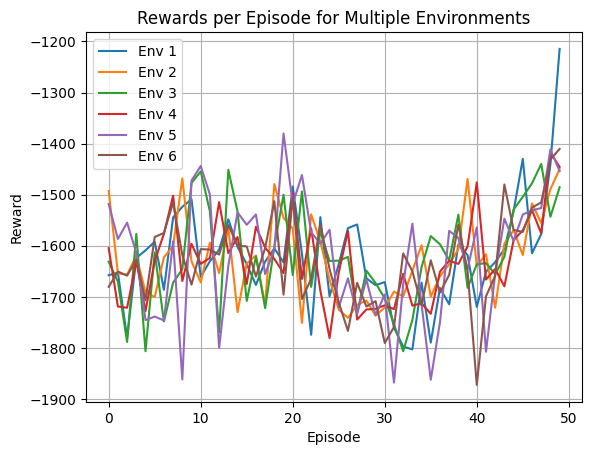

In [52]:
reward_list_t = np.transpose(reward_list)

for i in range(params['num_envs']):
    plt.plot(reward_list_t[i], label=f'Env {i+1}')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode for Multiple Environments')

plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


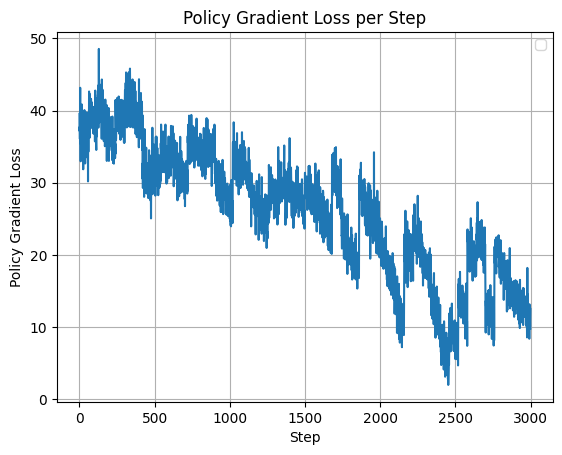

In [53]:
plt.plot(pg_loss_list)


plt.xlabel('Step')
plt.ylabel('Policy Gradient Loss')
plt.title('Policy Gradient Loss per Step')

plt.grid()
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


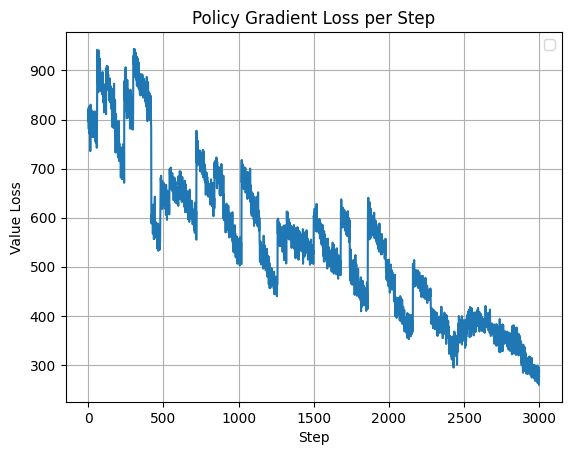

In [54]:
plt.plot(value_loss_list)

plt.xlabel('Step')
plt.ylabel('Value Loss')
plt.title('Policy Gradient Loss per Step')

plt.grid()
plt.legend()
plt.show()

# Testing

In [55]:
env = gym.make(params['env_id'])
reward_episodes = []
actions_list = []



for i in range(10):
    next_obs, _ = env.reset()
    next_obs = torch.Tensor(next_obs)
    terminated = False
    truncated = False
    reward_total = 0

    while not terminated and not truncated :
        state = torch.tensor(state)
        action = net.get_probs(next_obs).detach().numpy()
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        reward_total += reward

    reward_episodes.append(reward_total)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


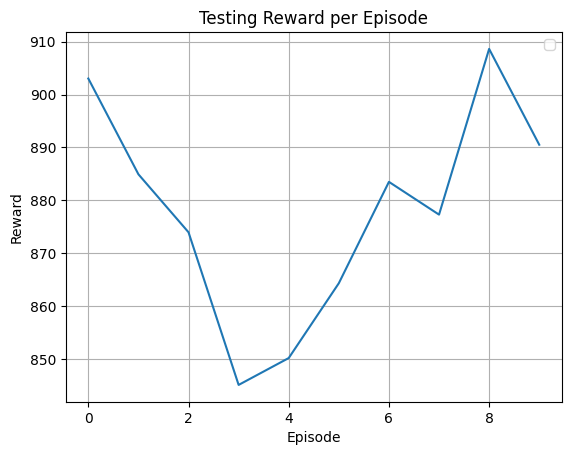

In [56]:
plt.plot(reward_episodes)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Testing Reward per Episode')

plt.grid()
plt.legend()
plt.show()